# Notebook de diseño de la Red Predictiva Fintech_LSTM

### Celdas de carga de librerías, paquetes, etc...

In [1]:
####################################################################################
# PASO 1: Importar todos los módulos necesarios
import sys
ENABLE_GOOGLE_COLAB = 'google.colab' in sys.modules
ENABLE_GOOGLE_COLAB

False

In [2]:
####################################################################################
if ENABLE_GOOGLE_COLAB:
  # Instalación de API de Google Drive para utilizar archivos en la nube
  !pip install -U -q PyDrive
  # Instala h5py
  !pip install h5py
  # Instala plot.ly
  !pip install plotly
  # TA-Lib: instalación y carga de la librería
  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  !make
  !make install
  !pip install Ta-Lib
  # Instalación de ngrok para visualización en tensorboard
  !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
  !unzip ngrok-stable-linux-amd64.zip
  from google.colab import auth
  from google.colab import files
  
####################################################################################
# incluye google drive api
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

####################################################################################
# Librerías de manejo de datos 
import pandas as pd
from pandas import concat
import numpy as np

####################################################################################
# Librerías de machine learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics as sk
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

####################################################################################
# Librerías de visualización
import matplotlib.pyplot as plt
from matplotlib import dates, ticker
from matplotlib.dates import (MONDAY, DateFormatter, MonthLocator, WeekdayLocator, date2num)
import matplotlib as mpl
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls
tls.set_credentials_file(username='raulMrello', api_key='qX9S30YRQ866mGF9b89u')

####################################################################################
# TA-Lib: instalación y carga de la librería
import talib

####################################################################################
# Otras utilidades
import datetime
import time
import os
import sys
import math

####################################################################################
print('Done!')

Using TensorFlow backend.


Done!


In [4]:
####################################################################################
# PASO 2a (google colab): Autenticación en Google Drive para obtener el archivo csv
if ENABLE_GOOGLE_COLAB:
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  #2. Obtiene el archivo
  downloaded = drive.CreateFile({'id':'12syio4J4xs-PFo_qNNWsNKvQhZb0nOaY'}) # replace the id with id of file you want to access
  downloaded.GetContentFile('EURUSD_H1.csv')  
  #downloaded = drive.CreateFile({'id':'1xuDgK4FteolMBiaYVRNWaofw36iQyRaV'}) # replace the id with id of file you want to access
  #downloaded.GetContentFile('EURUSD_M30.csv')  
  #downloaded = drive.CreateFile({'id':'18o564BOnayxVbbY2DR7BjGXY-zzk9PBd'}) # replace the id with id of file you want to access
  #downloaded.GetContentFile('test_fourier.csv')  

### Celdas de carga de datos históricos desde archivo csv a Pandas Dataframe

- Cargo el histórico en dataframe
- Puedo reindexar el timestamp a una cadencia fija (ej. 1 hora) y rellenar los gaps (NaN)
- Puedo visualizar el resultado en forma de gráfico de velas
- Añado tantas filas al final como predicciones se vayan a hacer

In [73]:
####################################################################################
# PASO 3: Carga el archivo csv en un dataframe, con posibilidad de rellenar espacios vacíos
def load_hist(filename, **kwargs):
    '''
        :param filename Archivo csv a leer
        :param kwargs lista de opciones:
            sep CSV Separator
            reindex_fillna Flag para rellenar espacios en blanco
            plot_it Flag para visualizar el archivo
        :return dataframe creado
    '''
    sep = ','
    reindex_fillna=False
    plot_it=False    
    if kwargs is not None:
        for key, value in kwargs.items():
            if key == 'sep': sep = value
            if key == 'reindex_fillna': reindex_fillna = value
            if key == 'plot_it': plot_it = value
                
    df = pd.read_csv(filename, sep=sep) 
    print(df.head(),'\r\n--------------------------')
    # crea una nueva columna de timestamp uniendo date & time y crea columnas para el día de la semana, el día del mes, el mes y la hora del día actual 
    df['timestamp'] = df['DATE'] + '  ' + df['TIME'] 
    df['timestamp'] = df['timestamp'].map(lambda x: datetime.datetime.strptime(x, '%Y.%m.%d %H:%M:%S'))  
    df['weekday'] = df['timestamp'].map(lambda x: x.dayofweek) 
    df['day'] = df['timestamp'].map(lambda x: x.day) 
    df['month'] = df['timestamp'].map(lambda x: x.month) 
    df['hhmm'] = df['timestamp'].map(lambda x: x.hour*60 + x.minute) 
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df[['timestamp','OPEN','HIGH','LOW','CLOSE','TICKVOL','VOL','SPREAD']]
    print(df.head(),'\r\n--------------------------')
    # establece como índice la columna de timestamp con una cadencia de 30min para encontrar los valores NaN
    if reindex_fillna:
        df.set_index('timestamp', inplace=True)
        df = df.reindex(pd.date_range(min(df.index), max(df.index), freq="1H"))
        # elimina los valores nulos y los rellena con el valor anterior
        df.fillna(method='ffill', inplace =True)
        print(df.head())
    if plot_it:
        plt.plot(df.OPEN)
        plt.plot(df.HIGH)
        plt.plot(df.LOW)
        plt.plot(df.CLOSE)
        plt.legend(['open','high','low','close'], loc='upper right')        
    return df
        
    
####################################################################################
####################################################################################

df = load_hist('EURUSD_H1_now.csv',sep=';', reindex_fillna=True, plot_it=False)   

# defino número de predicciones
num_out_steps = 4
delta = df.index[1] - df.index[0]
max_index = df.index[-1] + (num_out_steps*delta)
new_index = pd.date_range(min(df.index), max_index, freq="1H")
df = df.reindex(new_index)
df.loc[-num_out_steps:,:]=0
plot_resume = False
if plot_resume:
    # visualizo una sección
    trace = go.Candlestick(x=df.index[-100:],
                                   open=df.OPEN[-100:],
                                   high=df.HIGH[-100:],
                                   low=df.LOW[-100:],
                                   close=df.CLOSE[-100:])
    data = [trace]
    layout = go.Layout(
        autosize=False,
        width=1000,
        height=700,    
        title='Mostrando últimos 100 datos',
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
df.tail(10)
    

         DATE      TIME    OPEN    HIGH     LOW   CLOSE  TICKVOL  VOL  SPREAD
0  2001.10.01  00:00:00  0.9103  0.9112  0.9100  0.9107      108    0      50
1  2001.10.01  01:00:00  0.9107  0.9109  0.9098  0.9105      202    0      50
2  2001.10.01  02:00:00  0.9106  0.9109  0.9059  0.9076      441    0      50
3  2001.10.01  03:00:00  0.9078  0.9107  0.9073  0.9095      376    0      50
4  2001.10.01  04:00:00  0.9094  0.9106  0.9088  0.9101      275    0      50 
--------------------------
            timestamp    OPEN    HIGH     LOW   CLOSE  TICKVOL  VOL  SPREAD
0 2001-10-01 00:00:00  0.9103  0.9112  0.9100  0.9107      108    0      50
1 2001-10-01 01:00:00  0.9107  0.9109  0.9098  0.9105      202    0      50
2 2001-10-01 02:00:00  0.9106  0.9109  0.9059  0.9076      441    0      50
3 2001-10-01 03:00:00  0.9078  0.9107  0.9073  0.9095      376    0      50
4 2001-10-01 04:00:00  0.9094  0.9106  0.9088  0.9101      275    0      50 
--------------------------
                    

,OPEN,HIGH,LOW,CLOSE,TICKVOL,VOL,SPREAD
2018-10-31 05:00:00,1.13450,1.13487,1.13438,1.13439,1321.0,0.0,0.0
2018-10-31 06:00:00,1.13439,1.13448,1.13390,1.13408,1761.0,0.0,0.0
2018-10-31 07:00:00,1.13408,1.13429,1.13361,1.13421,1618.0,0.0,0.0
2018-10-31 08:00:00,1.13421,1.13474,1.13375,1.13421,2264.0,0.0,0.0
2018-10-31 09:00:00,1.13421,1.13464,1.13384,1.13448,2745.0,0.0,0.0
2018-10-31 10:00:00,1.13448,1.13536,1.13359,1.13472,8030.0,0.0,0.0
2018-10-31 11:00:00,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0
2018-10-31 12:00:00,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0
2018-10-31 13:00:00,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0
2018-10-31 14:00:00,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0


###  Elaboración de indicadores técnicos sintéticos

A partir de los datos OHLC, y la librería TA-Lib genero diversos indicadores sintéticos. En este caso he optado por predecir el precio de cierre 'close' y por lo tanto, todos los indicadores se aplicarán a dicho precio (aunque se podrían utilizar otros precios como 'high', 'low', 'open', etc...).

- bollWidthRel: Aporta la anchura de las bandas bollinger relativa a su propia SMA100
- bollR: Aporta la posición del precio en relación a la banda bollinger en %
- atr: Aporta la diferencia entre éste y el cierre de la sesión anterior
- SMAx3: Aporta 3 medias simples de 4,16 y 40 periodos
- Además también puedo añadir el propio precio ('close')

In [74]:
####################################################################################
# PASO 4: Crea columnas para diferentes indicadores TA-Lib, descarta el resto de columnas
def add_indicators(df, applied, indicators, **kwargs):
    '''
        :param df DataFrame de referencia
        :param applied Lista de precios a los que aplicar los indicadores
        :param indicators Lista de los indicadores a formar:
                    bollWidthRel - Anchura bandas bollinger relativa a la sma100 de la anchura
                    bollR - Posición del precio en la banda en %
                    atr - Average true range standar
                    SMAx3 - Triple media móvil superpuestas dos a dos
                    CLOSE - Datos en columna df.CLOSE
        :return dataframe actualizado
    '''
    df = df.copy()    
    cols = list()
    for p in applied:
        if df[p] is None: continue
        upperband, middleband, lowerband = talib.BBANDS(df[p], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
        bollinger_width = upperband - lowerband
        for i in indicators:
            if i+'_'+p in df.columns:
                continue                
            if i=='bollWidthRel':
                # obtengo columnas a partir de features TA-Lib            
                bollinger_width_sma50 = talib.SMA(bollinger_width, timeperiod=50)            
                df[i+'_'+p] = bollinger_width/(3*bollinger_width_sma50)
                cols.append(i+'_'+p)
                
            elif i=='bollR':
                if i+'_'+p in df.columns:
                    continue                
                bollR = (df[p] - lowerband)/(upperband - lowerband)
                bollR[np.isnan(bollR)]=0.5
                bollR[np.isinf(bollR)]=0.5
                df[i+'_'+p]=bollR
                cols.append(i+'_'+p)
                
            elif i=='atr':
                df[i+'_'+p] = talib.SMA((df[p] - df.CLOSE.shift(1)),timeperiod=14)
                cols.append(i+'_'+p)
              
            elif i=='SMAx3':            
                df['sma4_'+p] = talib.SMA(df.CLOSE,timeperiod=4)
                df['sma16_'+p] = talib.SMA(df.CLOSE,timeperiod=16)
                df['sma40_'+p] = talib.SMA(df.CLOSE,timeperiod=40)
                cols.append('sma4_'+p)
                cols.append('sma16_'+p)
                cols.append('sma40_'+p)
              
            elif i=='HIGH' or i=='LOW' or i== 'CLOSE' or i=='OPEN':
                if i in cols:
                    continue                
                cols.append(i)
                
            else:  
                print('Indicador "{}" desconocido'.format(i))
    
    
    plot_it = False
    starts = 0    
    plot_len = 0
    for key,val in kwargs.items():        
        if key=='plot_it': plot_it=val
        elif key=='starts': starts=val
        elif key=='plot_len': plot_len=val
        elif key=='add_applied':
            for i in applied:
                cols.append(i)
    
    df.dropna(inplace=True)    
    df = df[cols]
    if plot_it:
        plt.figure(figsize=(12,12))
        for i in cols:
            plt.subplot(len(cols), 1, cols.index(i)+1)
            plt.plot(df[i][starts:starts+plot_len])
            plt.title(i, y=0.5, loc='right')
    return df

####################################################################################
####################################################################################

dfapp = add_indicators(df, ['CLOSE'], ['bollWidthRel', 'bollR', 'atr', 'SMAx3'], add_applied=True)
dfapp['out'] = dfapp['CLOSE']
dfapp.dropna(inplace=True)
dfapp.tail(10)



,bollWidthRel_CLOSE,bollR_CLOSE,atr_CLOSE,sma4_CLOSE,sma16_CLOSE,sma40_CLOSE,CLOSE,out
2018-10-31 05:00:00,0.477066,2.874859e-01,-0.000193,1.134418e+00,1.135146,1.136745,1.13439,1.13439
2018-10-31 06:00:00,0.473075,2.507402e-01,-0.000242,1.134303e+00,1.135109,1.136611,1.13408,1.13408
2018-10-31 07:00:00,0.422336,2.936185e-01,-0.000222,1.134295e+00,1.134929,1.136501,1.13421,1.13421
2018-10-31 08:00:00,0.404788,3.144103e-01,-0.000156,1.134223e+00,1.134725,1.136430,1.13421,1.13421
2018-10-31 09:00:00,0.396317,3.893360e-01,-0.000054,1.134245e+00,1.134547,1.136329,1.13448,1.13448
2018-10-31 10:00:00,0.390415,4.434394e-01,-0.000009,1.134405e+00,1.134443,1.136223,1.13472,1.13472
2018-10-31 11:00:00,14.036060,-5.897161e-01,-0.081011,8.508525e-01,1.063491,1.107776,0.00000,0.00000
2018-10-31 12:00:00,8.954230,-2.499980e-01,-0.081041,5.673000e-01,0.992564,1.079306,0.00000,0.00000
2018-10-31 13:00:00,6.503855,-9.511859e-02,-0.081020,2.836800e-01,0.921679,1.050830,0.00000,0.00000
2018-10-31 14:00:00,5.071630,7.933802e-08,-0.081025,1.076916e-14,0.850768,1.022368,0.00000,0.00000


###  Adaptación de los datos para ejecución de la predicción 

El dataframe cargado tiene como último dato, la vela actual. Para evitar que durante la adaptación a 'supervised' se eliminen celdas válidas debido al dropna, es necesario añadir tantas filas al final como timesteps a generar en la predicción. De esta forma conseguimos que tras el dropna, la última fila sea exactamente la muestra actual.

In [75]:
####################################################################################
# PASO 5: Crea time-steps de las entradas y las salidas para la red LSTM
def series_to_supervised(df, num_inputs, num_outputs, n_in=1, n_out=1, dropnan=True):
  # obtengo el dataframe con las entradas y las salidas
  df_in = df[[x for x in df.columns if df.columns.get_loc(x) < num_inputs]]
  df_out = df[[x for x in df.columns if df.columns.get_loc(x)>=num_inputs]]
  
  cols, names = list(), list()
	# input sequence (t-n, ... t-1)
  for i in range(n_in-1, -1, -1):
    cols.append(df_in.shift(i))
    if i!=0:
      names += [('%s(t-%d)' % (df_in.columns[j], i)) for j in range(0, num_inputs)]
    else:
      names += [('%s(t)' % (df_in.columns[j])) for j in range(0, num_inputs)]
    
	# forecast sequence (t, t+1, ... t+n)
  for i in range(1, n_out+1):   
    cols.append(df_out.shift(-i))
    if i == 0:
      names += [('%s(t)' % (df_out.columns[j])) for j in range(0, num_outputs)]
    else:
      names += [('%s(t+%d)' % (df_out.columns[j], i)) for j in range(0, num_outputs)]
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

####################################################################################
####################################################################################

# Creo columnas para las 24 muestras de entradas t-1, ..., t-48 y para las dos salidas t, t+1
num_in_steps = 24
#num_out_steps = 4 (ver arriba)
num_outputs = 1
num_inputs = dfapp.shape[1] - num_outputs

sts_src = series_to_supervised(dfapp, num_inputs, num_outputs, num_in_steps, num_out_steps)
print('Número de muestras total: ', sts_src.shape[0])
sts_src.tail(10)

Número de muestras total:  149651


,bollWidthRel_CLOSE(t-23),bollR_CLOSE(t-23),atr_CLOSE(t-23),sma4_CLOSE(t-23),sma16_CLOSE(t-23),sma40_CLOSE(t-23),CLOSE(t-23),bollWidthRel_CLOSE(t-22),bollR_CLOSE(t-22),atr_CLOSE(t-22),...,bollR_CLOSE(t),atr_CLOSE(t),sma4_CLOSE(t),sma16_CLOSE(t),sma40_CLOSE(t),CLOSE(t),out(t+1),out(t+2),out(t+3),out(t+4)
2018-10-31 01:00:00,0.983124,0.246207,-0.000029,1.137328,1.138243,1.139242,1.13756,0.934952,0.286182,-0.000135,...,0.177936,-0.000250,1.134373,1.135694,1.137219,1.13429,1.13454,1.13424,1.13450,1.13439
2018-10-31 02:00:00,0.934952,0.286182,-0.000135,1.137435,1.138201,1.139179,1.13763,0.870657,0.288148,-0.000134,...,0.246093,-0.000143,1.134365,1.135581,1.137061,1.13454,1.13424,1.13450,1.13439,1.13408
2018-10-31 03:00:00,0.870657,0.288148,-0.000134,1.137513,1.138175,1.139114,1.13755,0.809019,0.471577,-0.000030,...,0.217732,-0.000109,1.134355,1.135359,1.136960,1.13424,1.13450,1.13439,1.13408,1.13421
2018-10-31 04:00:00,0.809019,0.471577,-0.000030,1.137735,1.138092,1.139065,1.13820,0.607901,0.505845,0.000082,...,0.287221,-0.000012,1.134393,1.135231,1.136873,1.13450,1.13439,1.13408,1.13421,1.13421
2018-10-31 05:00:00,0.607901,0.505845,0.000082,1.137893,1.138015,1.139015,1.13819,0.586090,0.478494,-0.000029,...,0.287486,-0.000193,1.134418,1.135146,1.136745,1.13439,1.13408,1.13421,1.13421,1.13448
2018-10-31 06:00:00,0.586090,0.478494,-0.000029,1.138010,1.137982,1.138964,1.13810,0.567956,0.388190,-0.000081,...,0.250740,-0.000242,1.134303,1.135109,1.136611,1.13408,1.13421,1.13421,1.13448,1.13472
2018-10-31 07:00:00,0.567956,0.388190,-0.000081,1.138080,1.138032,1.138906,1.13783,0.508826,0.269333,-0.000034,...,0.293619,-0.000222,1.134295,1.134929,1.136501,1.13421,1.13421,1.13448,1.13472,0.00000
2018-10-31 08:00:00,0.508826,0.269333,-0.000034,1.137888,1.137964,1.138837,1.13743,0.507290,-0.058552,-0.000175,...,0.314410,-0.000156,1.134223,1.134725,1.136430,1.13421,1.13448,1.13472,0.00000,0.00000
2018-10-31 09:00:00,0.507290,-0.058552,-0.000175,1.137428,1.137801,1.138742,1.13635,0.478530,0.475471,-0.000087,...,0.389336,-0.000054,1.134245,1.134547,1.136329,1.13448,1.13472,0.00000,0.00000,0.00000
2018-10-31 10:00:00,0.478530,0.475471,-0.000087,1.137350,1.137794,1.138683,1.13779,0.490728,0.045908,-0.000141,...,0.443439,-0.000009,1.134405,1.134443,1.136223,1.13472,0.00000,0.00000,0.00000,0.00000


### Normalización de los datos de entrada-salida

A continuación, se realiza la selección final de columnas del dataframe que se utilizará en la red neuronal y los datos se normalizarán utilizando un 'scaler' concreto. Dicho scaler se utilizará tras el proceso de predicción, para volver a de-normalizar el resultado y obtener su valor real.

Es posible reutilizar un scaler previamente guardado en disco, para ello activar el flag reuse_saved_scaler.

In [76]:
reuse_saved_scaler = True

# preparo los datos con numpy ndarray
values = sts_src.values
values = values.astype('float32')

if reuse_saved_scaler:
  # recupero el scaler del disco
  from sklearn.externals import joblib
  scaler_filename = "scaler.save"
  scaler = joblib.load(scaler_filename)  
  values = scaler.transform(values)
else:
  scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
  values = scaler.fit_transform(values)

# actualizo el dataframe
sts_scaled = pd.DataFrame(data=values, columns=sts_src.columns, index=sts_src.index)
sts_values = sts_scaled.values
sts_scaled.tail(10)


,bollWidthRel_CLOSE(t-23),bollR_CLOSE(t-23),atr_CLOSE(t-23),sma4_CLOSE(t-23),sma16_CLOSE(t-23),sma40_CLOSE(t-23),CLOSE(t-23),bollWidthRel_CLOSE(t-22),bollR_CLOSE(t-22),atr_CLOSE(t-22),...,bollR_CLOSE(t),atr_CLOSE(t),sma4_CLOSE(t),sma16_CLOSE(t),sma40_CLOSE(t),CLOSE(t),out(t+1),out(t+2),out(t+3),out(t+4)
2018-10-31 01:00:00,-0.882025,-0.232946,-0.087379,-0.211149,-0.208282,-0.206943,-0.211751,-0.887806,-0.196267,-0.119525,...,-0.295588,-0.154261,-0.218887,-0.214973,-0.212302,-0.220290,-0.219637,-0.220420,-0.219741,-0.220029
2018-10-31 02:00:00,-0.887806,-0.196267,-0.119525,-0.210867,-0.208394,-0.207111,-0.211568,-0.895521,-0.194463,-0.119310,...,-0.233051,-0.121899,-0.218906,-0.215270,-0.212719,-0.219637,-0.220420,-0.219741,-0.220029,-0.220838
2018-10-31 03:00:00,-0.895521,-0.194463,-0.119310,-0.210665,-0.208461,-0.207283,-0.211777,-0.902918,-0.026159,-0.087810,...,-0.259073,-0.111543,-0.218933,-0.215853,-0.212989,-0.220420,-0.219741,-0.220029,-0.220838,-0.220499
2018-10-31 04:00:00,-0.902918,-0.026159,-0.087810,-0.210082,-0.208678,-0.207413,-0.210079,-0.927052,0.005283,-0.053937,...,-0.195314,-0.082416,-0.218834,-0.216187,-0.213218,-0.219741,-0.220029,-0.220838,-0.220499,-0.220499
2018-10-31 05:00:00,-0.927052,0.005283,-0.053937,-0.209669,-0.208881,-0.207543,-0.210106,-0.929669,-0.019812,-0.087594,...,-0.195071,-0.137001,-0.218769,-0.216412,-0.213558,-0.220029,-0.220838,-0.220499,-0.220499,-0.219794
2018-10-31 06:00:00,-0.929669,-0.019812,-0.087594,-0.209362,-0.208966,-0.207680,-0.210341,-0.931845,-0.102671,-0.103128,...,-0.228787,-0.151888,-0.219070,-0.216509,-0.213912,-0.220838,-0.220499,-0.220499,-0.219794,-0.219167
2018-10-31 07:00:00,-0.931845,-0.102671,-0.103128,-0.209178,-0.208837,-0.207834,-0.211046,-0.938941,-0.211727,-0.089105,...,-0.189444,-0.145847,-0.219090,-0.216981,-0.214204,-0.220499,-0.220499,-0.219794,-0.219167,-3.182269
2018-10-31 08:00:00,-0.938941,-0.211727,-0.089105,-0.209682,-0.209014,-0.208015,-0.212090,-0.939125,-0.512576,-0.131607,...,-0.170367,-0.125782,-0.219280,-0.217516,-0.214391,-0.220499,-0.219794,-0.219167,-3.182269,-3.182269
2018-10-31 09:00:00,-0.939125,-0.512576,-0.131607,-0.210887,-0.209442,-0.208267,-0.214911,-0.942576,-0.022586,-0.105070,...,-0.101619,-0.094930,-0.219220,-0.217982,-0.214658,-0.219794,-0.219167,-3.182269,-3.182269,-3.182269
2018-10-31 10:00:00,-0.942576,-0.022586,-0.105070,-0.211090,-0.209462,-0.208425,-0.211150,-0.941113,-0.416729,-0.121251,...,-0.051977,-0.081338,-0.218801,-0.218256,-0.214939,-0.219167,-3.182269,-3.182269,-3.182269,-3.182269


### Definición de la red neuronal

In [77]:
####################################################################################
# PASO 13: Elije el archivo en el que se guardarán los pesos del modelo entrenado
file_weights = "model_weights_3110001.hdf5"

####################################################################################
# PASO 14: Crea el modelo de red neuronal

from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.constraints import max_norm

####################################################################################
# Métrica loss con dependencia del signo
def stock_loss(y_true, y_pred):
    alpha = 100.
    loss = K.switch(K.less(y_true * y_pred, 0), \
        alpha*y_pred**2 - K.sign(y_true)*y_pred + K.abs(y_true), \
        K.abs(y_true - y_pred)
        )
    return K.mean(loss, axis=-1)


####################################################################################
# Métrica RMSE
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))


####################################################################################
# Crea un modelo LSTM 
def build_stacked_lstm(num_cells, num_layers, num_inputs, num_in_steps, num_outputs, num_out_steps, batch_size, filepath):
  # Inicio definiendo un modelo secuencial
  model = Sequential()

  sequence_flag = False
  if num_layers > 1:
    sequence_flag = True
    
  # capa de entrada, debe especificar formato 'input_shape'
  model.add(LSTM(num_cells, return_sequences=sequence_flag, input_shape=(num_in_steps, num_inputs)))
  #model.add(BatchNormalization())
  model.add(Dropout(0.20))
  
  for i in range(1, num_layers, 1):
    if i == num_layers-1:
      sequence_flag = False
    # capas intermedias
    model.add(LSTM(num_cells, return_sequences=sequence_flag))
    #model.add(BatchNormalization())
    model.add(Dropout(0.20))
  
  # la capa de salida es una capa Dense con tantas salidas como timesteps a predecir con activación lineal     
  model.add(Dense(num_outputs * num_out_steps, activation='linear'))

  # compilo con optimizador Adam y pérdida 'mse'
  opt = keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False)
  model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])   

  #checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  #download_weights = DownloadWeights(filepath)
  #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
  #fitlogger = FitLogger('fit.csv')
  # callback para visualización en tensorboard
  #tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,write_graph=True,write_grads=True,batch_size=batch_size,write_images=True)
  callbacks_list = []  

  # si existe un modelo previo, lo carga
  try:
    model.load_weights(filepath)
    print('Loaded weights from file: ', filepath)
  except:
    print('No weights file to load')
    
  model.summary()
  return model, callbacks_list

####################################################################################
####################################################################################

num_cells = 128
num_layers = 3
batch_size=64
model, callbacks_list = build_stacked_lstm(num_cells, num_layers, num_inputs, num_in_steps, num_outputs, num_out_steps, batch_size, file_weights)


Loaded weights from file:  model_weights_3110001.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 24, 128)           69632     
_________________________________________________________________
dropout_10 (Dropout)         (None, 24, 128)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 24, 128)           131584    
_________________________________________________________________
dropout_11 (Dropout)         (None, 24, 128)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)       

# TEST

##### Hago un test de ejecución previo en un número de muestras pasadas

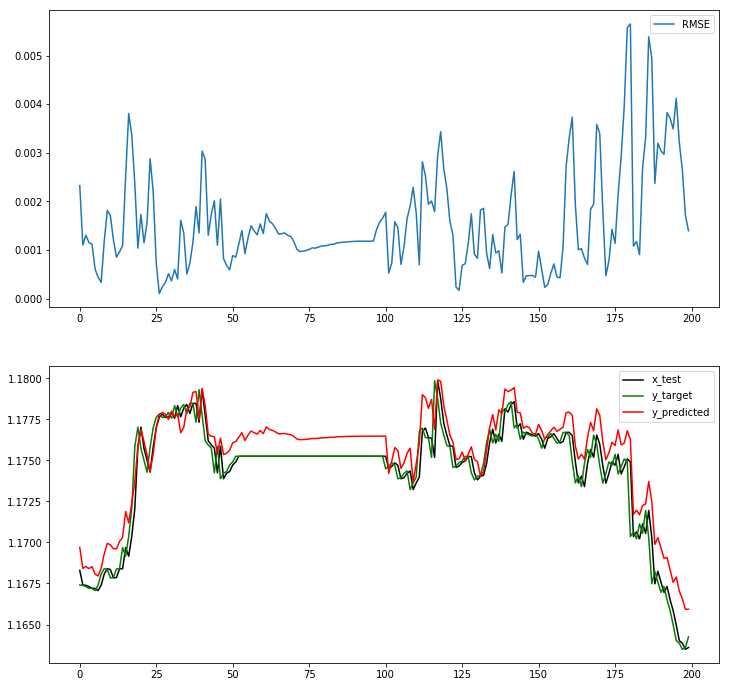

In [78]:
i,j=-1000,-800
test_data = sts_scaled.values[i:j]
x_data = test_data[:,:(num_in_steps * num_inputs)].reshape(test_data.shape[0], num_in_steps, num_inputs)
y_data = test_data[:,(num_in_steps * num_inputs):].reshape(test_data.shape[0], num_out_steps*num_outputs)

rmse = list()
inp,target,pred=list(),list(),list()
for sample in range(x_data.shape[0]):
    # Realizo predicción del primer conjunto de datos
    x = x_data[sample].reshape(1, num_in_steps, num_inputs)
    y = y_data[sample].reshape(1,num_outputs * num_out_steps)
    predictions = model.predict(x, batch_size=1,verbose=0)

    # deshago el scaling
    xy_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), y),axis=1)
    xy_values = scaler.inverse_transform(xy_values)
    xyhat_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), predictions),axis=1)
    xyhat_values = scaler.inverse_transform(xyhat_values)

    # Calculo el error RMSE
    rmse_val = math.sqrt(sk.mean_squared_error(xy_values[0,-(num_outputs * num_out_steps):], xyhat_values[0,-(num_outputs * num_out_steps):], multioutput = 'uniform_average'))
    rmse.append(rmse_val)
    inp.append(xy_values[0,-(num_outputs * num_out_steps)-1])
    target.append(xy_values[0,-(num_outputs * num_out_steps)])
    pred.append(xyhat_values[0,-(num_outputs * num_out_steps)])    

plt.figure(figsize=(12,12))    
plt.subplot(2,1,1)
plt.plot(np.asarray(rmse))    
plt.legend(['RMSE'])

# visualizo los resultados anteriores en un rango dado
plt.subplot(2,1,2)
plt.plot(np.asarray(inp).reshape((len(inp),)),color='black')
plt.plot(np.asarray(target).reshape((len(target),)),color='green')
plt.plot(np.asarray(pred).reshape((len(pred),)),color='red')
plt.legend(['x_test', 'y_target', 'y_predicted'])


# EJECUCIÓN

##### Chequeo el resultado de aplicar el conjunto de test para obtener el par (Loss, Accuracy)

Predictions:  [[-0.21097302 -0.21121515 -0.2110028  -0.21103933]]
Denormalized Predictions:  [1.1378579 1.137765  1.1378465 1.1378325]


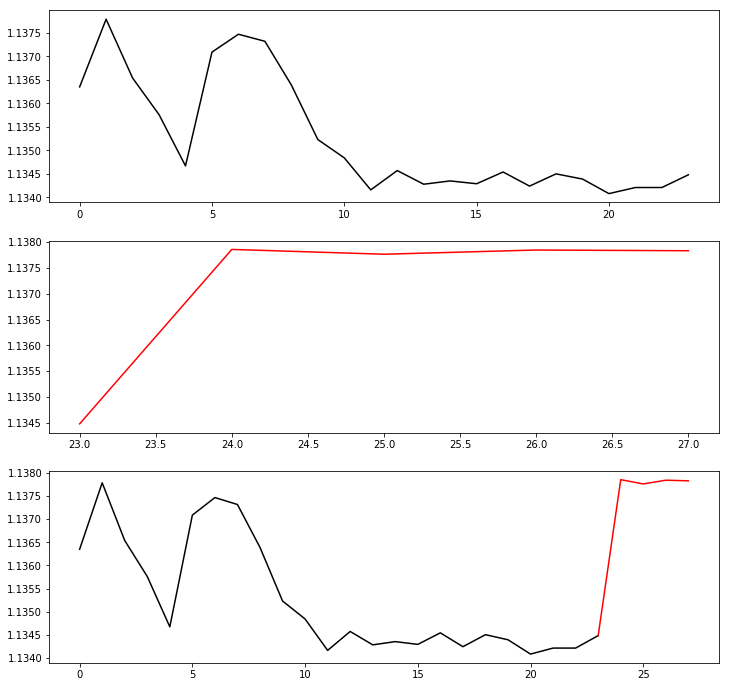

In [79]:
# Realizo predicción 
x = sts_scaled.values[-1,0:num_inputs*num_in_steps].reshape(1, num_in_steps, num_inputs)
predictions = model.predict(x, batch_size=1,verbose=0)
print('Predictions: ',predictions)

# deshago el scaling
xyhat_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), predictions),axis=1)
xyhat_values = scaler.inverse_transform(xyhat_values)
print('Denormalized Predictions: ',xyhat_values[0,num_inputs*num_in_steps:])

# Visualizo resultado
# creo array de resultado y paso como primer elemento el cierre actual
result = list()
result.append(sts_src.iloc[-1]['CLOSE(t-1)'])
# añado las predicciones
result = result + xyhat_values[0,-(num_outputs*num_out_steps):].tolist()
# reformateo a un array
result = np.asarray(result)

plt.figure(figsize=(12,12))  
plt.subplot(3,1,1)
plt.plot(sts_src.iloc[-num_in_steps:]['CLOSE(t-1)'].values, color='black')
plt.subplot(3,1,2)
plt.plot(np.arange(num_in_steps-1, num_in_steps + num_out_steps), result, color='red')
plt.subplot(3,1,3)
plt.plot(sts_src.iloc[-num_in_steps:]['CLOSE(t-1)'].values, color='black')
plt.plot(np.arange(num_in_steps-1, num_in_steps + num_out_steps), result, color='red')


### PREDICCIÓN A MEDIO PLAZO

Utilizando los últimos datos y la predicción para el instante actual, genero una serie de predicciones a futuro (medio plazo) ej. 96 sesiones (equivalen a 96 horas= 4 próximos días)

sample 1 de 500
sample 2 de 500
sample 3 de 500
sample 4 de 500
sample 5 de 500
sample 6 de 500
sample 7 de 500
sample 8 de 500
sample 9 de 500
sample 10 de 500
sample 11 de 500
sample 12 de 500
sample 13 de 500
sample 14 de 500
sample 15 de 500
sample 16 de 500
sample 17 de 500
sample 18 de 500
sample 19 de 500
sample 20 de 500
sample 21 de 500
sample 22 de 500
sample 23 de 500
sample 24 de 500
sample 25 de 500
sample 26 de 500
sample 27 de 500
sample 28 de 500
sample 29 de 500
sample 30 de 500
sample 31 de 500
sample 32 de 500
sample 33 de 500
sample 34 de 500
sample 35 de 500
sample 36 de 500
sample 37 de 500
sample 38 de 500
sample 39 de 500
sample 40 de 500
sample 41 de 500
sample 42 de 500
sample 43 de 500
sample 44 de 500
sample 45 de 500
sample 46 de 500
sample 47 de 500
sample 48 de 500
sample 49 de 500
sample 50 de 500
sample 51 de 500
sample 52 de 500
sample 53 de 500
sample 54 de 500
sample 55 de 500
sample 56 de 500
sample 57 de 500
sample 58 de 500
sample 59 de 500
sample

sample 463 de 500
sample 464 de 500
sample 465 de 500
sample 466 de 500
sample 467 de 500
sample 468 de 500
sample 469 de 500
sample 470 de 500
sample 471 de 500
sample 472 de 500
sample 473 de 500
sample 474 de 500
sample 475 de 500
sample 476 de 500
sample 477 de 500
sample 478 de 500
sample 479 de 500
sample 480 de 500
sample 481 de 500
sample 482 de 500
sample 483 de 500
sample 484 de 500
sample 485 de 500
sample 486 de 500
sample 487 de 500
sample 488 de 500
sample 489 de 500
sample 490 de 500
sample 491 de 500
sample 492 de 500
sample 493 de 500
sample 494 de 500
sample 495 de 500
sample 496 de 500
sample 497 de 500
sample 498 de 500
sample 499 de 500
sample 500 de 500


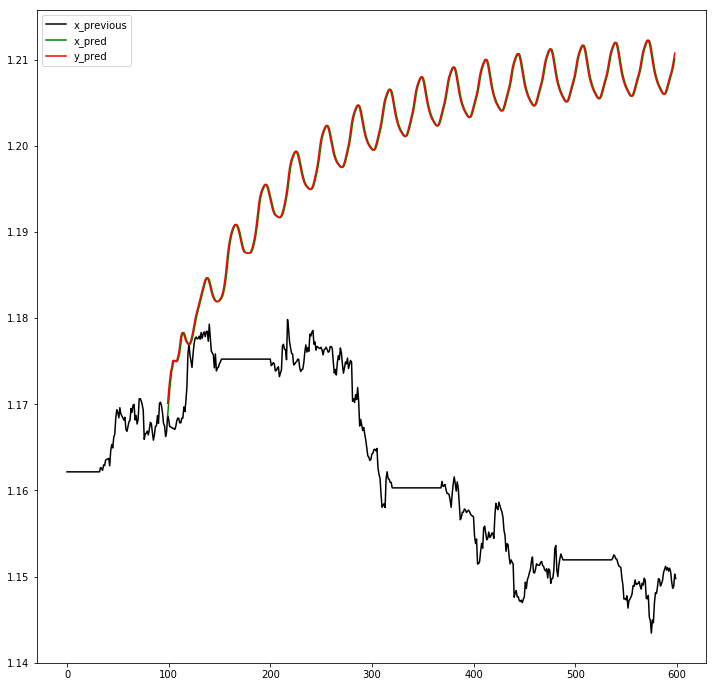

In [118]:
# @@@@@@@@@@@@@@@ CONFIG_SETUP

print_logs = False              # Flag para activar trazas de depuración de esta celda
test_len = 24                   # Establezco el número de muestras a futuro para realizar el test
predict_with_ctrol=False        # Establezco el modo de predicción (con o sin control)
ctrol_wdow = trvl_samples       # Establezco la ventana del dataframe 'df' a seleccionar (df[:-ctrol_wdow])
ctrol_wdow_prev=50              # Nº de muestras previas de control a visualizar
add_first_steps=True            # Flag para añadir las num_out_steps filas al final de dfpred antes del test

setup_test_with_ctrol=(False,24,True,trvl_samples,100,False)
setup_test_with_ctrol_no_previous=(False,24,True,trvl_samples,1,False)
setup_predict_future=(False,24,False,0,100,True)
setup_predict_future_noadd_steps=(False,24,False,0,100,False)

# @@@@@@@@@@@@@@@


# dpred contiene una copia del dataframe origen 'df' que puede ser:
# 1. Modo predicción con control de resultado (si dfpred+test_len es un slice de df)
# 2. Modo predicción a futuro real (si dfpred es una copia exacta de df)
dfpred = df.copy()
if add_first_steps:
  delta = dfpred.index[1] - dfpred.index[0]
  max_index = dfpred.index[-1] + (num_out_steps * delta)
  new_index = pd.date_range(min(dfpred.index), max_index, freq="1H")
  dfpred = dfpred.reindex(new_index)
  dfpred.loc[-num_out_steps:,:]=0   
    
control_data = dfpred[dfpred.shape[0] - num_out_steps-ctrol_wdow_prev:dfpred.shape[0] - num_out_steps]
if predict_with_ctrol:
  dfpred = df.loc[df.index <= sts_src.index[ctrol_wdow+num_out_steps]].copy()
  control_data = df[dfpred.shape[0] - num_out_steps-ctrol_wdow_prev:dfpred.shape[0] - num_out_steps+test_len]
    
# inicio sin ninguna predicción
ypred = np.nan

# creo lista para almacenar las predicciones de la red 
pred = list()

# para cada muestra de test
for sample in range(test_len):    
  # si hay muestra predicha del paso anterior, la reinserto como una nueva muestra actual
  if not np.isnan(ypred):
    dfpred.iloc[-num_out_steps]['CLOSE'] = ypred
    # añado una nueva fila al final y pongo sus valores a 0
    delta = dfpred.index[1] - dfpred.index[0]
    max_index = dfpred.index[-1] + delta
    new_index = pd.date_range(min(dfpred.index), max_index, freq="1H")
    dfpred = dfpred.reindex(new_index)
    dfpred.loc[-num_out_steps:,:]=0

  # en este punto dfpred es el dataframe original con 'num_out_steps' filas al final todas a 0.
  # añado indicadores técnicos
  dfapp_pred = add_indicators(dfpred, ['CLOSE'], ['bollWidthRel', 'bollR', 'atr', 'SMAx3'], add_applied=True)
  dfapp_pred['out'] = dfapp_pred['CLOSE']
  dfapp_pred.dropna(inplace=True)

  # en este punto dfapp_pred es el dataframe con todos los indicadores técnicos
  # creo modelo con formato de entrenamiento supervisado para el scaler
  sts_src_pred = series_to_supervised(dfapp_pred, num_inputs, num_outputs, num_in_steps, num_out_steps)

  # en este punto sts_src_pred tiene todos los datos listos antes de la normalización con 'scaler'   
  # normalizo los datos
  values = sts_src_pred.values
  values = values.astype('float32')
  values = scaler.transform(values)
  sts_scaled_pred = pd.DataFrame(data=values, columns=sts_src_pred.columns, index=sts_src_pred.index)
  sts_values = sts_scaled_pred.values

  # en este punto sts_scaled_pred tiene los valores listos para la red neuronal
  # genero una predicción
  x = sts_scaled_pred.values[-1,0:num_inputs*num_in_steps].reshape(1, num_in_steps, num_inputs)
  predictions = model.predict(x, batch_size=1,verbose=0)
  
  # en este punto ya tengo la siguiente predicción
  # deshago el scaling
  xyhat_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), predictions),axis=1)
  xyhat_values = scaler.inverse_transform(xyhat_values)
    
  # en este punto tengo el valor denormalizado de la predicción
  # guardo la última entrada aplicada y la predicción en t+1 para repetir el bucle
  xreal = xyhat_values[0,-(num_outputs*num_out_steps)-1]
  if np.isnan(ypred):
    pred.append(xreal)
  ypred = xyhat_values[0,num_inputs*num_in_steps]  
  pred.append(ypred)  
  print('sample {} de {}'.format(sample+1, test_len))


y_pred = np.asarray(pred).reshape((len(pred),))
x_pred_idx = np.arange(ctrol_wdow_prev-1,ctrol_wdow_prev-1+y_pred.shape[0])
x_previous = control_data['CLOSE'].values
y_trgt = np.asarray(targets).reshape((len(targets),))

plt.figure(figsize=(12,12)) 
plt.plot(np.arange(x_previous.shape[0]),x_previous, color='black')
plt.plot(x_pred_idx, y_pred, color='r')
if predict_with_ctrol:
  plt.legend(['y_target','y_pred'])
else:
  plt.legend(['x','y_pred'])
